In [32]:
import pandas as pd
import numpy  as np

np.random.seed(47)

import matplotlib.pyplot as plt
import seaborn           as sns

%matplotlib inline
sns.set(palette = 'mako', style = 'darkgrid')

from scipy.stats             import norm
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.dummy           import DummyClassifier
from sklearn.ensemble        import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold, KFold, GroupKFold
from sklearn.metrics         import make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [2]:
url = 'https://gist.githubusercontent.com/guilhermesilveira/4d1d4a16ccbf6ea4e0a64a38a24ec884/raw/afd05cb0c796d18f3f5a6537053ded308ba94bf7/car-prices.csv'

df = pd.read_csv(url)

In [3]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
sold_map = {
    'no':0,
    'yes':1
}

df.sold= df.sold.map(sold_map)

In [5]:
display(df.head())
display(df.shape)

,mileage_per_year,model_year,price,sold
0,21801,2000,30941.02,1
1,7843,1998,40557.96,1
2,7109,2006,89627.50,0
3,26823,2015,95276.14,0
4,7935,2014,117384.68,1


(10000, 4)

In [6]:
df.isnull().sum()

mileage_per_year    0
model_year          0
price               0
sold                0
dtype: int64

In [7]:
df.model_year = 2020 - df.model_year

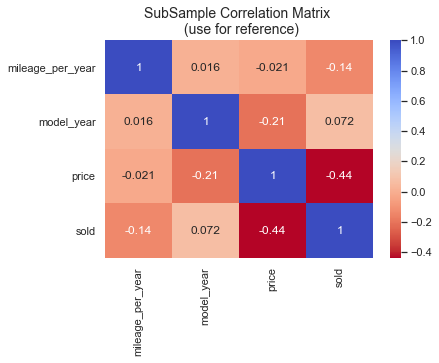

In [8]:
sub_sample_corr = df.corr()

ax = sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot = True)
ax.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

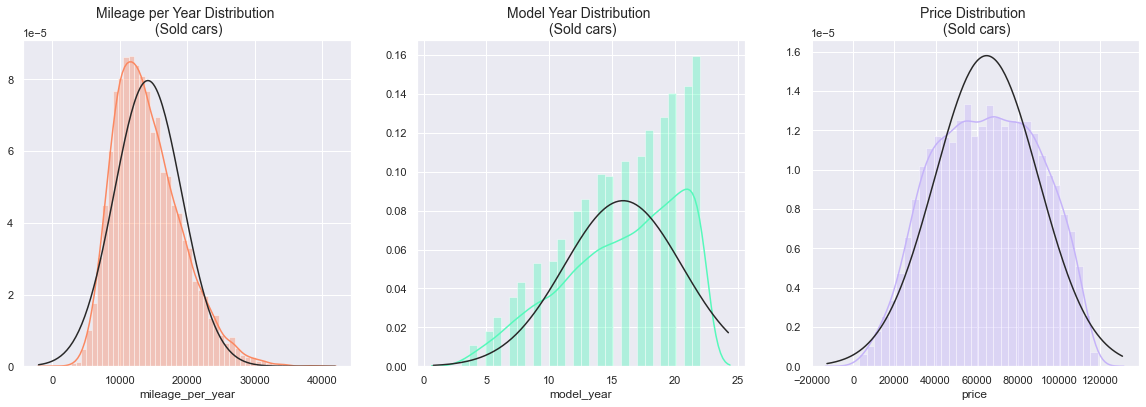

In [9]:
f, axes = plt.subplots(1, 3, figsize=(20, 6))

#milage per year dist plot
mileage_dist = df['mileage_per_year']

sns.distplot(mileage_dist, ax=axes[0], fit=norm, color='#FB8861')
axes[0].set_title('Mileage per Year Distribution \n (Sold cars)', fontsize=14)

#model year dist plot
model_dist = df['model_year']

sns.distplot(model_dist, ax=axes[1], fit=norm, color='#56F9BB')
axes[1].set_title('Model Year Distribution \n (Sold cars)', fontsize=14)

#price of model plot
price_dist = df['price']

sns.distplot(price_dist, ax=axes[2], fit=norm, color='#C5B3F9')
axes[2].set_title('Price Distribution \n (Sold cars)', fontsize=14)

plt.show()

In [10]:
# # -----> mileage_per_year Removing Outliers (Highest Negative Correlated with Labels)
q25, q75  = np.percentile(mileage_dist, 25), np.percentile(mileage_dist, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
mileage_iqr = q75 - q25
print('iqr: {}'.format(mileage_iqr))

mileage_cut_off             = mileage_iqr * 1.5
mileage_lower, mileage_upper = q25 - mileage_cut_off, q75 + mileage_cut_off
print('Cut Off: {}'.format(mileage_cut_off))
print('mileage Lower {}'.format(mileage_lower))
print('mileage Upper: {}'.format(mileage_upper))

outliers = [x for x in mileage_dist if x < mileage_lower or x > mileage_upper]
print('Feature mileage_per_year Outliers: {}'.format(len(outliers)))
print('mileage_per_year outliers:{}'.format(outliers))

df = df.drop(df[(df['mileage_per_year'] > mileage_upper) | (df['mileage_per_year'] < mileage_lower)].index)
print('----' * 44)

Quartile 25: 10474.75 | Quartile 75: 17176.75
iqr: 6702.0
Cut Off: 10053.0
mileage Lower 421.75
mileage Upper: 27229.75
Feature mileage_per_year Outliers: 146
mileage_per_year outliers:[28915, 27565, 28868, 27781, 27585, 28770, 27768, 37394, 39226, 363, 31071, 27865, 28383, 28357, 31268, 31500, 28473, 27386, 32244, 28479, 28400, 33669, 34889, 28297, 34137, 30104, 34786, 29780, 27404, 28025, 27720, 29884, 27366, 28711, 27670, 28880, 30074, 27585, 30680, 28122, 32351, 39572, 27430, 34029, 34491, 30125, 28945, 38023, 27892, 30457, 28082, 29810, 29122, 27674, 28027, 34786, 32096, 29444, 29326, 29226, 27689, 28570, 29285, 28428, 30479, 30684, 29105, 28272, 29683, 27946, 27282, 30130, 30572, 31870, 33046, 32090, 30600, 29175, 31226, 31169, 27925, 32435, 28874, 31167, 27872, 29574, 30729, 31256, 28547, 27325, 29069, 27948, 29639, 33919, 27383, 27633, 33575, 27297, 30963, 27307, 30902, 38307, 27515, 27491, 32962, 27775, 30695, 28674, 30121, 31928, 27484, 29745, 31605, 28923, 33474, 27632, 2815

In [11]:
X = df.drop('sold', axis = 1)
y = df['sold']

In [12]:
scaler   = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [13]:
scaled_X

,mileage_per_year,model_year,price
0,1.688429,0.884126,-1.341980
1,-1.314198,1.311298,-0.961086
2,-1.472096,-0.397391,0.982390
3,2.768756,-2.319665,1.206114
4,-1.294408,-2.106079,2.081757
...,...,...,...
9849,0.348454,-0.397391,1.278860
9850,-0.151912,0.456954,1.687274
9851,-0.200959,-2.106079,1.149906
9852,-0.750372,-1.465321,-0.537588


<h2>Cross-val Functions</h2>

In [15]:
def valid(y_pred, y_test):
    #printing the model's root mean squared logarithm error
    print(f'accuracy:    {((accuracy_score(y_test, y_pred))*100).round(3)}%')
    
    #printing model's precision
    print(f'precisão:    {(precision_score(y_test, y_pred)*100).round(3)}%')
      
    #printing model's recall
    print(f'recall:      {(recall_score(y_test, y_pred)*100).round(3)}%')
    
    #printing model's f1_score
    print(f'f1_score:    {(f1_score(y_test, y_pred)*100).round(3)}%')
     
    #confusion_matrix
    plt.rcParams['figure.figsize'] = (10, 6)
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap= 'mako_r')
    ax.set_title("Confusion Matrix", fontsize=14)
    ax.set_xticklabels(['not sold', 'sold'], fontsize=14, rotation=90)
    ax.set_yticklabels(['not sold', 'sold'], fontsize=14, rotation=360)

In [17]:
def k_valid(model, X, y, cv):
    
    scoring = {'accuracy'  : make_scorer(accuracy_score), 
               'precision' : make_scorer(precision_score),
               'recall'    : make_scorer(recall_score), 
               'f1_score'  : make_scorer(f1_score)}
    
    kfold = KFold(n_splits = cv, shuffle = False)
    #usar o stratified, quando houver desbalanço entre as classes
    
    results = cross_validate(model, X, y, scoring = scoring, cv = kfold)
    
    #printing the model's root mean squared logarithm error
    mean_accuracy  = results['test_accuracy'].mean()
    std_accuracy   = results['test_accuracy'].std()
    accuracy_lower = np.round((mean_accuracy - std_accuracy)*100, 3)
    accuracy_upper = np.round((mean_accuracy + std_accuracy)*100, 3)
    print(f'accuracy:     [{accuracy_lower}%, {accuracy_upper}%]')
    
    #printing model's precision
    mean_precision  = results['test_precision'].mean()
    std_precision   = results['test_precision'].std()
    precision_lower = np.round((mean_precision - std_precision)*100, 3)
    precision_upper = np.round((mean_precision + std_precision)*100, 3)
    print(f'precision:    [{precision_lower}%, {precision_upper}%]')
      
    #printing model's recall
    mean_recall  = results['test_recall'].mean()
    std_recall   = results['test_recall'].std()
    recall_lower = np.round((mean_recall - std_recall)*100, 3)
    recall_upper = np.round((mean_recall + std_recall)*100, 3)
    print(f'recall:       [{recall_lower}%, {recall_upper}%]')
    
    #printing model's f1_score
    mean_f1_score  = results['test_f1_score'].mean()
    std_f1_score   = results['test_f1_score'].std()
    f1_score_lower = np.round((mean_f1_score - std_f1_score)*100, 3)
    f1_score_upper = np.round((mean_f1_score + std_f1_score)*100, 3)
    print(f'f1_score:     [{f1_score_lower}%, {f1_score_upper}%]')

In [16]:
def stratified_k_valid(model, X, y, cv):
    
    scoring = {'accuracy'  : make_scorer(accuracy_score), 
               'precision' : make_scorer(precision_score),
               'recall'    : make_scorer(recall_score), 
               'f1_score'  : make_scorer(f1_score)}
    
    kfold = StratifiedKFold(n_splits = cv, shuffle = True)
    #usar o stratified, quando houver desbalanço entre as classes
    
    results = cross_validate(model, X, y, scoring = scoring, cv = kfold)
    
    #printing the model's root mean squared logarithm error
    mean_accuracy  = results['test_accuracy'].mean()
    std_accuracy   = results['test_accuracy'].std()
    accuracy_lower = np.round((mean_accuracy - std_accuracy)*100, 3)
    accuracy_upper = np.round((mean_accuracy + std_accuracy)*100, 3)
    print(f'accuracy:     [{accuracy_lower}%, {accuracy_upper}%]')
    
    #printing model's precision
    mean_precision  = results['test_precision'].mean()
    std_precision   = results['test_precision'].std()
    precision_lower = np.round((mean_precision - std_precision)*100, 3)
    precision_upper = np.round((mean_precision + std_precision)*100, 3)
    print(f'precision:    [{precision_lower}%, {precision_upper}%]')
      
    #printing model's recall
    mean_recall  = results['test_recall'].mean()
    std_recall   = results['test_recall'].std()
    recall_lower = np.round((mean_recall - std_recall)*100, 3)
    recall_upper = np.round((mean_recall + std_recall)*100, 3)
    print(f'recall:       [{recall_lower}%, {recall_upper}%]')
    
    #printing model's f1_score
    mean_f1_score  = results['test_f1_score'].mean()
    std_f1_score   = results['test_f1_score'].std()
    f1_score_lower = np.round((mean_f1_score - std_f1_score)*100, 3)
    f1_score_upper = np.round((mean_f1_score + std_f1_score)*100, 3)
    print(f'f1_score:     [{f1_score_lower}%, {f1_score_upper}%]')

In [18]:
def group_k_valid(model, X, y, cv, group_column):
    
    scoring = {'accuracy'  : make_scorer(accuracy_score), 
               'precision' : make_scorer(precision_score),
               'recall'    : make_scorer(recall_score), 
               'f1_score'  : make_scorer(f1_score)}
    
    kfold = GroupKFold(n_splits = cv)
    #usar o stratified, quando houver desbalanço entre as classes
    
    results = cross_validate(model, X, y, scoring = scoring, cv = kfold,
                             groups = group_column)
    
    #printing the model's root mean squared logarithm error
    mean_accuracy  = results['test_accuracy'].mean()
    std_accuracy   = results['test_accuracy'].std()
    accuracy_lower = np.round((mean_accuracy - std_accuracy)*100, 3)
    accuracy_upper = np.round((mean_accuracy + std_accuracy)*100, 3)
    print(f'accuracy:     [{accuracy_lower}%, {accuracy_upper}%]')
    
    #printing model's precision
    mean_precision  = results['test_precision'].mean()
    std_precision   = results['test_precision'].std()
    precision_lower = np.round((mean_precision - std_precision)*100, 3)
    precision_upper = np.round((mean_precision + std_precision)*100, 3)
    print(f'precision:    [{precision_lower}%, {precision_upper}%]')
      
    #printing model's recall
    mean_recall  = results['test_recall'].mean()
    std_recall   = results['test_recall'].std()
    recall_lower = np.round((mean_recall - std_recall)*100, 3)
    recall_upper = np.round((mean_recall + std_recall)*100, 3)
    print(f'recall:       [{recall_lower}%, {recall_upper}%]')
    
    #printing model's f1_score
    mean_f1_score  = results['test_f1_score'].mean()
    std_f1_score   = results['test_f1_score'].std()
    f1_score_lower = np.round((mean_f1_score - std_f1_score)*100, 3)
    f1_score_upper = np.round((mean_f1_score + std_f1_score)*100, 3)
    print(f'f1_score:     [{f1_score_lower}%, {f1_score_upper}%]')

<h2> Baseline </h2>

In [19]:
dummy = DummyClassifier()
k_valid(dummy, scaled_X, y, cv = 10)

accuracy:     [48.767%, 53.263%]
precision:    [55.483%, 60.231%]
recall:       [56.006%, 60.193%]
f1_score:     [55.948%, 59.974%]


C:\Users\duelz\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


<h2>Random Forest</h2>

In [20]:
mdl_random = RandomForestClassifier(n_jobs = -1, random_state = 0, n_estimators = 500,
                                    min_samples_leaf = 32, max_features = 'auto',
                                    max_depth = 10)

<h3>Testing KFold</h3>

In [21]:
k_valid(mdl_random, scaled_X, y, cv = 10)

accuracy:     [76.665%, 79.028%]
precision:    [80.775%, 85.62%]
recall:       [76.277%, 78.816%]
f1_score:     [78.788%, 81.724%]


<h3>Testing StratifiedKFold for unbalanced data</h3>

In [ ]:
stratified_k_valid(mdl_random, scaled_X, y, cv = 10)

<h3>
      Generating random data from the car model, to simulate future grouping
</h3>

In [22]:
df['random_model'] = df.model_year + np.random.randint(-2, 3, size = len(df))

In [23]:
df.head()

,mileage_per_year,model_year,price,sold,random_model
0,21801,20,30941.02,1,19
1,7843,22,40557.96,1,20
2,7109,14,89627.50,0,15
3,26823,5,95276.14,0,7
4,7935,6,117384.68,1,7


In [24]:
df.random_model = df.random_model + abs(df.random_model.min()) + 1

In [27]:
X_group = df.drop('sold', axis = 1)
y_group = df['sold']

scaled_X_group = pd.DataFrame(scaler.fit_transform(X_group), columns = X_group.columns)

<h3>Testing GroupKFold for group data</h3>

In [29]:
group_k_valid(mdl_random, scaled_X_group, y_group, cv = 10, group_column = scaled_X_group.random_model)

accuracy:     [76.489%, 80.336%]
precision:    [80.44%, 86.858%]
recall:       [75.143%, 80.867%]
f1_score:     [78.217%, 83.157%]


<h2>Pipeline</h2>

In [35]:
pipe = Pipeline([('scaling', scaler), ('estimator', mdl_random)])
pipe

Pipeline(steps=[('scaling', StandardScaler()),
                ('estimator',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=32,
                                        n_estimators=500, n_jobs=-1,
                                        random_state=0))])

In [36]:
def pipeline_k_valid(pipeline, X, y, cv, group_column):
    
    scoring = {'accuracy'  : make_scorer(accuracy_score), 
               'precision' : make_scorer(precision_score),
               'recall'    : make_scorer(recall_score), 
               'f1_score'  : make_scorer(f1_score)}
    
    kfold = GroupKFold(n_splits = cv)
    #usar o stratified, quando houver desbalanço entre as classes
    
    results = cross_validate(pipeline, X, y, scoring = scoring, cv = kfold,
                             groups = group_column)
    
    #printing the model's root mean squared logarithm error
    mean_accuracy  = results['test_accuracy'].mean()
    std_accuracy   = results['test_accuracy'].std()
    accuracy_lower = np.round((mean_accuracy - std_accuracy)*100, 3)
    accuracy_upper = np.round((mean_accuracy + std_accuracy)*100, 3)
    print(f'accuracy:     [{accuracy_lower}%, {accuracy_upper}%]')
    
    #printing model's precision
    mean_precision  = results['test_precision'].mean()
    std_precision   = results['test_precision'].std()
    precision_lower = np.round((mean_precision - std_precision)*100, 3)
    precision_upper = np.round((mean_precision + std_precision)*100, 3)
    print(f'precision:    [{precision_lower}%, {precision_upper}%]')
      
    #printing model's recall
    mean_recall  = results['test_recall'].mean()
    std_recall   = results['test_recall'].std()
    recall_lower = np.round((mean_recall - std_recall)*100, 3)
    recall_upper = np.round((mean_recall + std_recall)*100, 3)
    print(f'recall:       [{recall_lower}%, {recall_upper}%]')
    
    #printing model's f1_score
    mean_f1_score  = results['test_f1_score'].mean()
    std_f1_score   = results['test_f1_score'].std()
    f1_score_lower = np.round((mean_f1_score - std_f1_score)*100, 3)
    f1_score_upper = np.round((mean_f1_score + std_f1_score)*100, 3)
    print(f'f1_score:     [{f1_score_lower}%, {f1_score_upper}%]')

In [37]:
pipeline_k_valid(pipe, X_group, y_group, cv = 10, group_column = X_group.random_model)

accuracy:     [76.321%, 80.42%]
precision:    [80.145%, 87.067%]
recall:       [75.097%, 80.882%]
f1_score:     [78.091%, 83.214%]
